<a href="https://colab.research.google.com/github/AilingLiu/Survival_analysis/blob/master/Use_Survival_analysis_to_Estimate_Customer_Churn_Rate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
mpl.rc('xtick', labelsize=14)
mpl.rc('ytick', labelsize=14)

In [38]:
url = 'https://raw.githubusercontent.com/AilingLiu/Survival_analysis/master/Data/Telco-Customer-Churn.csv'
df = pd.read_csv(url, sep=',')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customerID          7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
Churn               7043 non-null object
dtypes: float64(1), int64(2), obj

# Multivariate statistical modeling

Kaplan-Meier curves and logrank tests are useful only when the predictor variable is categorical (e.g.: treatment A vs treatment B; males vs females). They don’t work easily for quantitative predictors such as gene expression, weight, or age.

An alternative method is the Cox proportional hazards regression analysis, which works for both quantitative predictor variables and for categorical variables. Furthermore, the Cox regression model extends survival analysis methods to assess simultaneously the effect of several risk factors on survival time. [Referrence](http://www.sthda.com/english/wiki/cox-proportional-hazards-model)

To apply the cox model, we will need to encode the categorical variables, converting to numerical values.

In [29]:
# Check the number of levels in each categorical variable
object_cols = df.drop(columns=['customerID', 'TotalCharges']).select_dtypes(include='object').columns
unique_levels = pd.DataFrame({'unique_levels': [0]*len(object_cols)}, index=object_cols)

for col in object_cols:
  unique_levels.loc[col, 'unique_levels'] = df[col].nunique()

unique_levels

,unique_levels
gender,2
Partner,2
Dependents,2
PhoneService,2
MultipleLines,3
InternetService,3
OnlineSecurity,3
OnlineBackup,3
DeviceProtection,3
TechSupport,3


In [30]:
# get dummies, and drop the first level for each variable
df_enc = pd.get_dummies(df[object_cols.tolist()+['tenure', 'MonthlyCharges']], prefix=object_cols, columns=object_cols, drop_first=True)
df_enc.head()

,tenure,MonthlyCharges,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn_Yes
0,1,29.85,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
1,34,56.95,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0
2,2,53.85,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1
3,45,42.30,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0
4,2,70.70,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1


Note, when I start to apply coxphfitter function, it failed due to non-convergence. The reason is the suspicion is high collinearity. According to [Cam Davidson Pilon](https://github.com/CamDavidsonPilon/lifelines/blob/master/examples/Customer%20Churn.ipynb), some of the features have heirarchical natures. Such as, if one doesn't have internet service, their online security is not applicable, because `no internet service'. The best way is to treat the hierachical nature by stratifying on the different services a user may have. Here I will stratifying users based on if they have internet service on not. 
Besides, we also need to revise the 'No internet service' to no.

In [0]:
pip install lifelines

In [44]:
object_cols = df.drop(columns=['customerID', 'TotalCharges', 'InternetService']).select_dtypes(include='object').columns
fix_ = df[object_cols].applymap(lambda x: "No" if str(x).startswith("No ") else x)
ndf = fix_.join(df[['tenure', 'MonthlyCharges', 'InternetService', 'SeniorCitizen']])

# get dummies, and drop the first level for each variable
df_enc = pd.get_dummies(ndf, prefix=object_cols, columns=object_cols, drop_first=True)
df_enc.head()

,tenure,MonthlyCharges,InternetService,SeniorCitizen,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_Yes,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn_Yes
0,1,29.85,DSL,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0
1,34,56.95,DSL,0,1,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0,1,0
2,2,53.85,DSL,0,1,0,0,1,0,1,1,0,0,0,0,0,0,1,0,0,1,1
3,45,42.30,DSL,0,1,0,0,0,0,1,0,1,1,0,0,1,0,0,0,0,0,0
4,2,70.70,Fiber optic,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1


In [48]:
from lifelines import CoxPHFitter

cph = CoxPHFitter().fit(df_enc, 'tenure', 'Churn_Yes', strata=['InternetService'], show_progress=True)

Iteration 1: norm_delta = 0.98279, step_size = 0.9500, log_lik = -13939.15726, newton_decrement = 1216.50145, seconds_since_start = 0.1
Iteration 2: norm_delta = 0.54478, step_size = 0.9500, log_lik = -12622.10675, newton_decrement = 114.63648, seconds_since_start = 0.1
Iteration 3: norm_delta = 0.27378, step_size = 0.9500, log_lik = -12491.76849, newton_decrement = 16.27780, seconds_since_start = 0.2
Iteration 4: norm_delta = 0.08833, step_size = 1.0000, log_lik = -12473.37044, newton_decrement = 0.96046, seconds_since_start = 0.2
Iteration 5: norm_delta = 0.00743, step_size = 1.0000, log_lik = -12472.36338, newton_decrement = 0.00580, seconds_since_start = 0.3
Iteration 6: norm_delta = 0.00005, step_size = 1.0000, log_lik = -12472.35755, newton_decrement = 0.00000, seconds_since_start = 0.3
Iteration 7: norm_delta = 0.00000, step_size = 1.0000, log_lik = -12472.35755, newton_decrement = 0.00000, seconds_since_start = 0.4
Convergence success after 7 iterations.


In [49]:
cph.print_summary()

As you can see here, the `print_summary` output did not show the natural p value nor concordance value like the [documented example](https://github.com/CamDavidsonPilon/lifelines/blob/master/examples/Customer%20Churn.ipynb). I've raised this question on stackoverflow. But we can get the concordance index as below. Since -log2(p) is infinite, the p should be very small.

In [50]:
cph.concordance_index_

0.845766778773345

## Interpretation

In [57]:
cph.summary.sort_values(by='coef', ascending=True)

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,z,p,-log2(p)
Contract_Two year,-2.984923,0.050543,0.167697,-3.313603,-2.656242,0.036385,0.070212,-17.799497,7.130621e-71,233.022867
Contract_One year,-1.551826,0.211861,0.088079,-1.724458,-1.379195,0.178270,0.251781,-17.618635,1.772313e-69,228.387405
OnlineBackup_Yes,-0.644977,0.524675,0.126852,-0.893603,-0.396351,0.409179,0.672770,-5.084475,3.686450e-07,21.371264
OnlineSecurity_Yes,-0.630808,0.532162,0.133028,-0.891539,-0.370077,0.410024,0.690681,-4.741907,2.117153e-06,18.849443
Partner_Yes,-0.523961,0.592171,0.055271,-0.632289,-0.415632,0.531374,0.659923,-9.479886,2.545616e-21,68.412475
MultipleLines_Yes,-0.441122,0.643314,0.126249,-0.688566,-0.193678,0.502296,0.823923,-3.494056,4.757406e-04,11.037537
TechSupport_Yes,-0.389890,0.677131,0.132206,-0.649010,-0.130771,0.522563,0.877419,-2.949109,3.186913e-03,8.293625
DeviceProtection_Yes,-0.306533,0.735994,0.125269,-0.552057,-0.061010,0.575765,0.940814,-2.446996,1.440523e-02,6.117263
PaymentMethod_Credit card (automatic),-0.093749,0.910511,0.090769,-0.271653,0.084155,0.762118,1.087798,-1.032830,3.016834e-01,1.728893
gender_Male,-0.093636,0.910614,0.046474,-0.184724,-0.002548,0.831334,0.997456,-2.014784,4.392729e-02,4.508739


In [63]:
cph.log_likelihood_ratio_test()

TypeError: ignored

In [64]:
cph.check_assumptions(df_enc)

The ``p_value_threshold`` is set at 0.01. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.





1. Variable 'MultipleLines_Yes' failed the non-proportional test: p-value is 0.0126.

   Advice: with so few unique values (only 2), you can include `strata=['MultipleLines_Yes', ...]`
in the call in `.fit`. See documentation in link [E] below.

2. Variable 'Contract_One year' failed the non-proportional test: p-value is <5e-05.

   Advice: with so few unique values (only 2), you can include `strata=['Contract_One year', ...]`
in the call in `.fit`. See documentation in link [E] below.

3. Variable 'Contract_Two year' failed the non-proportional test: p-value is <5e-05.

   Advice: with so few unique values (only 2), you can include `strata=['Contract_Two year', ...]`
in the call in `.fit`. See documentation in link [E] below.

4. Variable 'PaymentMethod_Electronic check' failed the non-proportional test: p-value is 0.0035.

   Advice: with so few unique values (only 2), you can include `strata=['PaymentMethod_Electronic
check', ...]` in the call in `.fit`. See documentation in link 

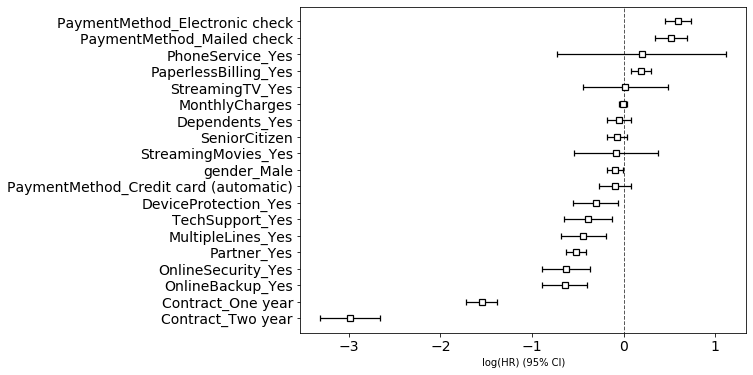

In [47]:
ax = plt.subplots(figsize=(8, 6))
cph.plot(ax=ax[1])